<a href="https://colab.research.google.com/github/Rosefinch-Midsummer/Awesome-Colab/blob/master/fastai/11_train_imagenette%2Btransfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
!git clone https://github.com/fastai/course-v3 

Cloning into 'course-v3'...
remote: Enumerating objects: 5333, done.
remote: Total 5333 (delta 0), reused 0 (delta 0), pack-reused 5333
Receiving objects: 100% (5333/5333), 257.77 MiB | 37.67 MiB/s, done.
Resolving deltas: 100% (2885/2885), done.


In [95]:
cd course-v3/nbs/dl2

/content/course-v3/nbs/dl2/course-v3/nbs/dl2


In [0]:
!git clone https://www.github.com/nvidia/apex  && cd apex/apex/fp16_utils

Cloning into 'apex'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 5627 (delta 17), reused 19 (delta 9), pack-reused 5585
Receiving objects: 100% (5627/5627), 13.37 MiB | 14.10 MiB/s, done.
Resolving deltas: 100% (3638/3638), done.


In [0]:
#export
#手动修改apex引用
from exp.nb_10b import *

## Imagenet(te) training

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=1681)

In [0]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [0]:
size = 128
tfms = [make_rgb, RandomResizedCrop(size, scale=(0.35,1)), np_to_float, PilRandomFlip()]

bs = 64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

ll.valid.x.tfms = [make_rgb, CenterCrop(size), np_to_float]

data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=8)

## XResNet

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=1701)

In [0]:
#export
def noop(x): return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

In [0]:
#export
act_fn = nn.ReLU(inplace=True)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

In [0]:
#export
class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

In [0]:
#export
class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=1000):
        nfs = [c_in, (c_in+1)*8, 64, 64]
        stem = [conv_layer(nfs[i], nfs[i+1], stride=2 if i==0 else 1)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        res = cls(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *res_layers,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(nfs[-1]*expansion, c_out),
        )
        init_cnn(res)
        return res

    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(n_blocks)])

In [0]:
#export
def xresnet18 (**kwargs): return XResNet.create(1, [2, 2,  2, 2], **kwargs)
def xresnet34 (**kwargs): return XResNet.create(1, [3, 4,  6, 3], **kwargs)
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)
def xresnet101(**kwargs): return XResNet.create(4, [3, 4, 23, 3], **kwargs)
def xresnet152(**kwargs): return XResNet.create(4, [3, 8, 36, 3], **kwargs)

## Train

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=2515)

In [0]:
cbfs = [partial(AvgStatsCallback,accuracy), ProgressCallback, CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette),
#         partial(MixUp, alpha=0.2)
       ]

In [0]:
loss_func = LabelSmoothingCrossEntropy()
arch = partial(xresnet18, c_out=10)
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [0]:
#export
def get_batch(dl, learn):
    learn.xb,learn.yb = next(iter(dl))
    learn.do_begin_fit(0)
    learn('begin_batch')
    learn('after_fit')
    return learn.xb,learn.yb

We need to replace the old `model_summary` since it used to take a `Runner`.

In [0]:
# export
def model_summary(model, data, find_all=False, print_mod=False):
    xb,yb = get_batch(data.valid_dl, learn)
    mods = find_modules(model, is_lin_layer) if find_all else model.children()
    f = lambda hook,mod,inp,out: print(f"====\n{mod}\n" if print_mod else "", out.shape)
    with Hooks(mods, f) as hooks: learn.model(xb)

In [0]:
learn = Learner(arch(), data, loss_func, lr=1, cb_funcs=cbfs, opt_func=opt_func)

In [0]:
learn.model = learn.model.cuda()
model_summary(learn.model, data, print_mod=False)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


 torch.Size([128, 32, 64, 64])
 torch.Size([128, 64, 64, 64])
 torch.Size([128, 64, 64, 64])
 torch.Size([128, 64, 32, 32])
 torch.Size([128, 64, 32, 32])
 torch.Size([128, 128, 16, 16])
 torch.Size([128, 256, 8, 8])
 torch.Size([128, 512, 4, 4])
 torch.Size([128, 512, 1, 1])
 torch.Size([128, 512])
 torch.Size([128, 10])


In [0]:
arch = partial(xresnet34, c_out=10)

In [0]:
learn = Learner(arch(), data, loss_func, lr=1, cb_funcs=cbfs, opt_func=opt_func)

In [0]:
learn.fit(1, cbs=[LR_Find(), Recorder()])

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


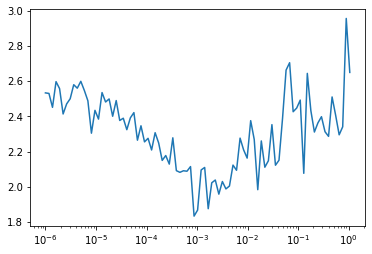

In [0]:
learn.recorder.plot(3)

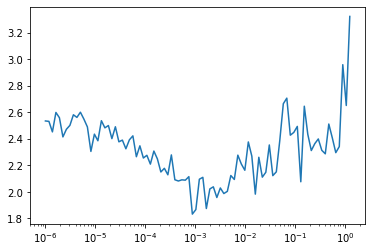

In [0]:
learn.recorder.plot(2)

In [0]:
#export
def create_phases(phases):
    phases = listify(phases)
    return phases + [1-sum(phases)]

In [0]:
print(create_phases(0.3))
print(create_phases([0.3,0.2]))

[0.3, 0.7]
[0.3, 0.2, 0.5]


In [0]:
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

In [0]:
cbsched = [
    ParamScheduler('lr', sched_lr),
    ParamScheduler('mom', sched_mom)]

In [0]:
learn = Learner(arch(), data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

In [0]:
learn.fit(5, cbs=cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.681132,0.500310,1.560446,0.544000,00:26
1,1.484560,0.595393,1.477090,0.594000,00:26
2,1.315970,0.659144,1.345616,0.662000,00:26
3,1.152849,0.732821,1.050014,0.776000,00:26
4,0.980319,0.805103,0.889432,0.850000,00:25


## cnn_learner

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=2711)

In [0]:
#export
def cnn_learner(arch, data, loss_func, opt_func, c_in=None, c_out=None,
                lr=1e-2, cuda=True, norm=None, progress=True, mixup=0, xtra_cb=None, **kwargs):
    cbfs = [partial(AvgStatsCallback,accuracy)]+listify(xtra_cb)
    if progress: cbfs.append(ProgressCallback)
    if cuda:     cbfs.append(CudaCallback)
    if norm:     cbfs.append(partial(BatchTransformXCallback, norm))
    if mixup:    cbfs.append(partial(MixUp, mixup))
    arch_args = {}
    if not c_in : c_in  = data.c_in
    if not c_out: c_out = data.c_out
    if c_in:  arch_args['c_in' ]=c_in
    if c_out: arch_args['c_out']=c_out
    return Learner(arch(**arch_args), data, loss_func, opt_func=opt_func, lr=lr, cb_funcs=cbfs, **kwargs)

In [0]:
learn = cnn_learner(xresnet34, data, loss_func, opt_func, norm=norm_imagenette)

In [0]:
learn.fit(5, cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.724481,0.480766,1.969499,0.468000,00:25
1,1.474604,0.599426,1.616168,0.548000,00:26
2,1.334939,0.658523,1.393514,0.660000,00:25
3,1.150174,0.730029,1.098431,0.750000,00:25
4,0.984134,0.803164,0.887951,0.852000,00:25


## Imagenet

You can see all this put together in the fastai [imagenet training script](https://github.com/fastai/fastai/blob/master/examples/train_imagenet.py). It's the same as what we've seen so far, except it also handles multi-GPU training. So how well does this work?

We trained for 60 epochs, and got an error of 5.9%, compared to the official PyTorch resnet which gets 7.5% error in 90 epochs! Our xresnet 50 training even surpasses standard resnet 152, which trains for 50% more epochs and has 3x as many layers.

## Export

In [0]:
#!./notebook2script.py 11_train_imagenette.ipynb

# Transfer Learning

In [0]:
#export
#手动修改
#from exp.nb_10b import *
from exp.nb_11 import *

## Serializing the model

[Jump_to lesson 12 video](https://course.fast.ai/videos/?lesson=12&t=2920)

In [0]:
path = datasets.untar_data(datasets.URLs.IMAGEWOOF_160)

In [0]:
size = 128
bs = 64

tfms = [make_rgb, RandomResizedCrop(size, scale=(0.35,1)), np_to_float, PilRandomFlip()]
val_tfms = [make_rgb, CenterCrop(size), np_to_float]
il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
ll.valid.x.tfms = val_tfms
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=8)

In [100]:
len(il)

12954

In [0]:
loss_func = LabelSmoothingCrossEntropy()
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [0]:
learn = cnn_learner(xresnet34, data, loss_func, opt_func, norm=norm_imagenette)

In [0]:
def sched_1cycle(lr, pct_start=0.3, mom_start=0.95, mom_mid=0.85, mom_end=0.95):
    phases = create_phases(pct_start)
    sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
    sched_mom = combine_scheds(phases, cos_1cycle_anneal(mom_start, mom_mid, mom_end))
    return [ParamScheduler('lr', sched_lr),
            ParamScheduler('mom', sched_mom)]

In [0]:
lr = 3e-3
pct_start = 0.5
cbsched = sched_1cycle(lr, pct_start)

In [105]:
learn.fit(10, cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.118752,0.255902,2.043383,0.302000,00:25
1,1.947613,0.341657,1.994734,0.310000,00:25
2,1.851105,0.392324,2.070750,0.314000,00:24
3,1.761844,0.433917,2.089828,0.376000,00:24
4,1.654115,0.489883,1.760113,0.422000,00:24
5,1.533624,0.547053,1.533224,0.518000,00:24
6,1.402140,0.605107,1.418052,0.596000,00:24
7,1.294221,0.660029,1.344788,0.646000,00:24
8,1.177083,0.711659,1.153012,0.718000,00:24
9,1.110532,0.743295,1.130334,0.730000,00:24


In [0]:
st = learn.model.state_dict()

In [107]:
type(st)

collections.OrderedDict

In [108]:
', '.join(st.keys())

'0.0.weight, 0.1.weight, 0.1.bias, 0.1.running_mean, 0.1.running_var, 0.1.num_batches_tracked, 1.0.weight, 1.1.weight, 1.1.bias, 1.1.running_mean, 1.1.running_var, 1.1.num_batches_tracked, 2.0.weight, 2.1.weight, 2.1.bias, 2.1.running_mean, 2.1.running_var, 2.1.num_batches_tracked, 4.0.convs.0.0.weight, 4.0.convs.0.1.weight, 4.0.convs.0.1.bias, 4.0.convs.0.1.running_mean, 4.0.convs.0.1.running_var, 4.0.convs.0.1.num_batches_tracked, 4.0.convs.1.0.weight, 4.0.convs.1.1.weight, 4.0.convs.1.1.bias, 4.0.convs.1.1.running_mean, 4.0.convs.1.1.running_var, 4.0.convs.1.1.num_batches_tracked, 4.1.convs.0.0.weight, 4.1.convs.0.1.weight, 4.1.convs.0.1.bias, 4.1.convs.0.1.running_mean, 4.1.convs.0.1.running_var, 4.1.convs.0.1.num_batches_tracked, 4.1.convs.1.0.weight, 4.1.convs.1.1.weight, 4.1.convs.1.1.bias, 4.1.convs.1.1.running_mean, 4.1.convs.1.1.running_var, 4.1.convs.1.1.num_batches_tracked, 4.2.convs.0.0.weight, 4.2.convs.0.1.weight, 4.2.convs.0.1.bias, 4.2.convs.0.1.running_mean, 4.2.convs

In [109]:
st['10.bias']

tensor([ 0.0041, -0.0084, -0.0120,  0.0014, -0.0038,  0.0140, -0.0194, -0.0017,
         0.0225,  0.0025], device='cuda:0')

In [0]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)

It's also possible to save the whole model, including the architecture, but it gets quite fiddly and we don't recommend it. Instead, just save the parameters, and recreate the model directly.

In [0]:
torch.save(st, mdl_path/'iw5')

## Pets

In [0]:
pets = datasets.untar_data(datasets.URLs.PETS)

In [113]:
pets.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [0]:
pets_path = pets/'images'

In [0]:
il = ImageList.from_files(pets_path, tfms=tfms)

In [116]:
il

ImageList (7390 items)
[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_184.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/leonberger_119.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_109.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Persian_184.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_135.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/beagle_186.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_63.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_190.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_96.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_22.jpg')...]
Path: /root/.fastai/data/oxford-iiit-pet/images

In [0]:
def random_splitter(fn, p_valid): return random.random() < p_valid

In [0]:
random.seed(42)

In [0]:
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid=0.1))

In [120]:
sd

SplitData
Train: ImageList (6667 items)
[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_184.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_109.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Persian_184.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_135.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/beagle_186.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_63.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_96.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/havanese_39.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Birman_193.jpg'), PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_12.jpg')...]
Path: /root/.fastai/data/oxford-iiit-pet/images
Valid: ImageList (723 items)
[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/leonberger_119.jpg'), PosixPath('/root/.fastai/data/oxford-iii

In [121]:
n = il.items[0].name; n

'wheaten_terrier_184.jpg'

In [122]:
re.findall(r'^(.*)_\d+.jpg$', n)[0]

'wheaten_terrier'

In [0]:
def pet_labeler(fn): return re.findall(r'^(.*)_\d+.jpg$', fn.name)[0]

In [0]:
proc = CategoryProcessor()

In [0]:
ll = label_by_func(sd, pet_labeler, proc_y=proc)

In [126]:
', '.join(proc.vocab)

'wheaten_terrier, english_cocker_spaniel, Persian, Russian_Blue, beagle, pomeranian, american_bulldog, havanese, Birman, pug, english_setter, Maine_Coon, yorkshire_terrier, american_pit_bull_terrier, leonberger, basset_hound, Abyssinian, scottish_terrier, Sphynx, samoyed, german_shorthaired, Ragdoll, shiba_inu, great_pyrenees, miniature_pinscher, Siamese, japanese_chin, staffordshire_bull_terrier, British_Shorthair, chihuahua, Egyptian_Mau, boxer, keeshond, saint_bernard, Bombay, newfoundland, Bengal'

In [0]:
ll.valid.x.tfms = val_tfms

In [0]:
c_out = len(proc.vocab)

In [0]:
data = ll.to_databunch(bs, c_in=3, c_out=c_out, num_workers=8)

In [0]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, norm=norm_imagenette)

In [131]:
learn.fit(5, cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,3.475543,0.090445,3.600489,0.076072,00:31
1,3.309807,0.126744,4.182246,0.060858,00:31
2,3.118645,0.182241,2.994389,0.226833,00:31
3,2.818073,0.268787,2.833347,0.257261,00:31
4,2.542160,0.362532,2.558384,0.348548,00:31


## Custom head

In [0]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette)

In [0]:
st = torch.load(mdl_path/'iw5')

In [0]:
m = learn.model

In [0]:
m.load_state_dict(st)

In [0]:
cut = next(i for i,o in enumerate(m.children()) if isinstance(o,nn.AdaptiveAvgPool2d))
m_cut = m[:cut]

In [137]:
xb,yb = get_batch(data.valid_dl, learn)
pred = m_cut(xb)
pred.shape

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


torch.Size([128, 512, 4, 4])

In [0]:
ni = pred.shape[1]

In [0]:
#export
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=1):
        super().__init__()
        self.output_size = sz
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [0]:
nh = 40

m_new = nn.Sequential(
    m_cut, AdaptiveConcatPool2d(), Flatten(),
    nn.Linear(ni*2, data.c_out))

In [0]:
learn.model = m_new

In [142]:
learn.fit(5, cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,3.039843,0.213889,2.620772,0.315353,00:31
1,2.455566,0.384281,2.831413,0.308437,00:31
2,2.227544,0.459577,2.388638,0.420470,00:31
3,1.958571,0.565022,1.965660,0.535270,00:31
4,1.702606,0.665817,1.774089,0.630705,00:31


## adapt_model and gradual unfreezing

In [0]:
def adapt_model(learn, data):
    cut = next(i for i,o in enumerate(learn.model.children())
               if isinstance(o,nn.AdaptiveAvgPool2d))
    m_cut = learn.model[:cut]
    xb,yb = get_batch(data.valid_dl, learn)
    pred = m_cut(xb)
    ni = pred.shape[1]
    m_new = nn.Sequential(
        m_cut, AdaptiveConcatPool2d(), Flatten(),
        nn.Linear(ni*2, data.c_out))
    learn.model = m_new

In [144]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette)
learn.model.load_state_dict(torch.load(mdl_path/'iw5'))

RuntimeError: ignored

In [145]:
adapt_model(learn, data)
for p in learn.model[0].parameters(): p.requires_grad_(False)
learn.fit(3, sched_1cycle(1e-2, 0.5))

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,3.052923,0.215689,3.126107,0.242047,00:30
1,3.179918,0.283036,3.056355,0.279391,00:30
2,2.466437,0.412629,2.374542,0.405256,00:30


In [146]:
for p in learn.model[0].parameters(): p.requires_grad_(True)
learn.fit(5, cbsched, reset_opt=True)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.171253,0.488976,2.659279,0.358230,00:31
1,2.210810,0.475026,2.944379,0.297372,00:31
2,2.155772,0.488376,2.737494,0.355463,00:31
3,1.901159,0.581221,1.946199,0.556017,00:31
4,1.650301,0.681716,1.810194,0.590595,00:31


## Batch norm transfer

In [147]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette)
learn.model.load_state_dict(torch.load(mdl_path/'iw5'))
adapt_model(learn, data)

RuntimeError: ignored

In [0]:
def apply_mod(m, f):
    f(m)
    for l in m.children(): apply_mod(l, f)

def set_grad(m, b):
    if isinstance(m, (nn.Linear,nn.BatchNorm2d)): return
    if hasattr(m, 'weight'):
        for p in m.parameters(): p.requires_grad_(b)

In [0]:
apply_mod(learn.model, partial(set_grad, b=False))

In [150]:
learn.fit(3, sched_1cycle(1e-2, 0.5))

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


RuntimeError: ignored

In [0]:
apply_mod(learn.model, partial(set_grad, b=True))

In [0]:
learn.fit(5, cbsched, reset_opt=True)

Pytorch already has an apply method we can use:

In [0]:
learn.model.apply(partial(set_grad, b=False));

## Discriminative LR and param groups

In [0]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette)

In [154]:
learn.model.load_state_dict(torch.load(mdl_path/'iw5'))
adapt_model(learn, data)

RuntimeError: ignored

In [0]:
def bn_splitter(m):
    def _bn_splitter(l, g1, g2):
        if isinstance(l, nn.BatchNorm2d): g2 += l.parameters()
        elif hasattr(l, 'weight'): g1 += l.parameters()
        for ll in l.children(): _bn_splitter(ll, g1, g2)
        
    g1,g2 = [],[]
    _bn_splitter(m[0], g1, g2)
    
    g2 += m[1:].parameters()
    return g1,g2

In [0]:
a,b = bn_splitter(learn.model)

In [0]:
test_eq(len(a)+len(b), len(list(m.parameters())))

In [0]:
Learner.ALL_CBS

In [0]:
from types import SimpleNamespace
cb_types = SimpleNamespace(**{o:o for o in Learner.ALL_CBS})

In [0]:
cb_types.after_backward

In [0]:
#export
class DebugCallback(Callback):
    _order = 999
    def __init__(self, cb_name, f=None): self.cb_name,self.f = cb_name,f
    def __call__(self, cb_name):
        if cb_name==self.cb_name:
            if self.f: self.f(self.run)
            else:      set_trace()

In [0]:
#export
def sched_1cycle(lrs, pct_start=0.3, mom_start=0.95, mom_mid=0.85, mom_end=0.95):
    phases = create_phases(pct_start)
    sched_lr  = [combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
                 for lr in lrs]
    sched_mom = combine_scheds(phases, cos_1cycle_anneal(mom_start, mom_mid, mom_end))
    return [ParamScheduler('lr', sched_lr),
            ParamScheduler('mom', sched_mom)]

In [0]:
disc_lr_sched = sched_1cycle([0,3e-2], 0.5)

In [0]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func,
                    c_out=10, norm=norm_imagenette, splitter=bn_splitter)

learn.model.load_state_dict(torch.load(mdl_path/'iw5'))
adapt_model(learn, data)

In [0]:
def _print_det(o): 
    print (len(o.opt.param_groups), o.opt.hypers)
    raise CancelTrainException()

learn.fit(1, disc_lr_sched + [DebugCallback(cb_types.after_batch, _print_det)])

In [0]:
learn.fit(3, disc_lr_sched)

In [0]:
disc_lr_sched = sched_1cycle([1e-3,1e-2], 0.3)

In [0]:
learn.fit(5, disc_lr_sched)

## Export

In [0]:
!./notebook2script.py 11a_transfer_learning.ipynb